In [1]:
!pip install -q efficientnet


In [2]:
import tensorflow as tf
import keras 
import efficientnet.tfkeras as efn
import os, shutil,re
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from kaggle_datasets import  KaggleDatasets
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)


Using TensorFlow backend.


Device: grpc://10.0.0.2:8470
Number of replicas: 8


In [26]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
GCS_PATH=KaggleDatasets().get_gcs_path()
BATCH_SIZE=16* strategy.num_replicas_in_sync
IMAGE_SIZE=[512,512]
EPOCHS=20


In [4]:
filenames =tf.io.gfile.glob(str(GCS_PATH+'/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH+'/chest_xray/val/*/*')))

train_files,val_files=train_test_split(filenames,test_size=0.2)
len(train_files)

4185

In [5]:
# file=filenames
for file in [train_files, val_files]:
    
    NORMAL=len([files for files in file if 'NORMAL' in files])
    PNEUMONIA=len([files for files in file if 'PNEUMONIA' in files])
    print('normal cases {}'.format(NORMAL))
    print('pneumonia cases {}'.format(PNEUMONIA))

normal cases 1080
pneumonia cases 3105
normal cases 269
pneumonia cases 778


In [6]:
train_list_ds=tf.data.Dataset.from_tensor_slices(train_files)
val_list_ds=tf.data.Dataset.from_tensor_slices(val_files)

for f in train_list_ds.take(3):
    print(f.numpy())
    
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)
    

b'gs://kds-f7d1bbdb79eb80095a7b7dbba47f21699f2b83ce017ae67f3c2f82a6/chest_xray/train/NORMAL/IM-0645-0001.jpeg'
b'gs://kds-f7d1bbdb79eb80095a7b7dbba47f21699f2b83ce017ae67f3c2f82a6/chest_xray/train/NORMAL/NORMAL2-IM-0939-0001.jpeg'
b'gs://kds-f7d1bbdb79eb80095a7b7dbba47f21699f2b83ce017ae67f3c2f82a6/chest_xray/train/PNEUMONIA/person494_virus_1000.jpeg'
['NORMAL' 'PNEUMONIA']


In [7]:
def get_labels(file_path):
    parts=tf.strings.split(file_path,os.path.sep)
    
    return parts[-2]=='PNEUMONIA'

In [8]:
def decode_image(img):
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    return tf.image.resize(img,IMAGE_SIZE)

In [9]:
def process_path(path):
    label=get_labels(path)
    img=tf.io.read_file(path)
    img=decode_image(img)
    return img,label



In [10]:
train_ds=train_list_ds.map(process_path,num_parallel_calls=AUTOTUNE)
val_ds=val_list_ds.map(process_path,num_parallel_calls=AUTOTUNE)


In [11]:
for imag,lab in train_ds.take(1):
    print(imag.numpy().shape
         )
    print("LABEL: {}".format(lab))

(180, 180, 3)
LABEL: False


In [12]:
##create test list and pipeline


test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT



624

In [13]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache,str):
            ds=ds.cache(cache)
        else:
            ds=ds.cache()
            
    ds=ds.shuffle(buffer_size=shuffle_buffer_size)
    ds=ds.repeat()
    ds=ds.batch(BATCH_SIZE)
    ds=ds.prefetch(buffer_size=AUTOTUNE)
    return ds

            
            

In [14]:
train_ds=prepare_for_training(train_ds)
val_ds=prepare_for_training(val_ds)
image_batch,label_batch=next(iter(train_ds))

In [15]:
def show_batch(imahe_batch,label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax=plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
            
        plt.axis("off")
    

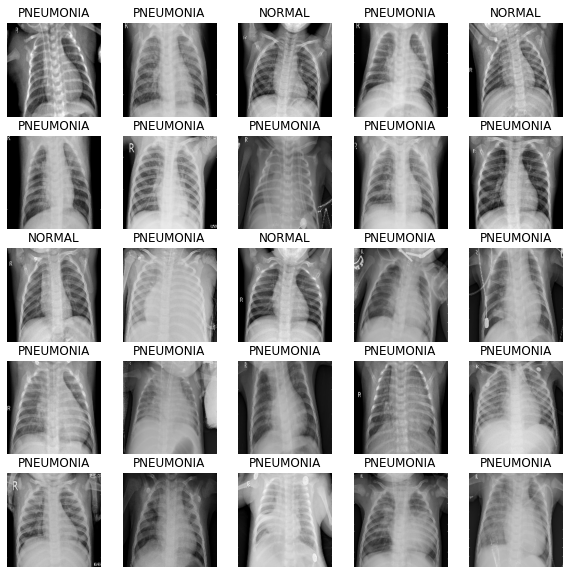

In [16]:
show_batch(image_batch.numpy(),label_batch.numpy())

In [ ]:

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

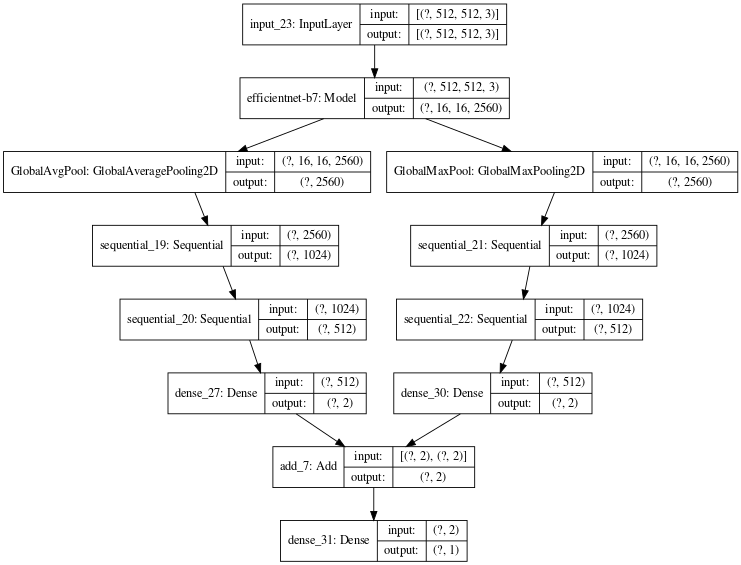

In [52]:
efficient_net = efn.EfficientNetB7(
    input_shape=(512, 512, 3),
    weights='imagenet',
    include_top=False
)

inp = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = efficient_net(inp)
gap = keras.layers.GlobalAveragePooling2D(name='GlobalAvgPool')(x)
gap=dense_block(1024, 0.4)(gap)
gap=dense_block(512, 0.4)(gap)
gap = keras.layers.Dense(2, activation='linear')(gap)

gmp = keras.layers.GlobalMaxPooling2D(name='GlobalMaxPool')(x)
gmp=dense_block(1024, 0.4)(gmp)
gmp=dense_block(512, 0.4)(gmp)
# gmp=dense_block(64, 0.3)(gmp)
       
gmp = keras.layers.Dense(2, activation='linear')(gmp)

out = keras.layers.add([gap, gmp])
out = keras.layers.Dense(1, activation='sigmoid')(out)
       
model = keras.Model(inputs=inp, outputs=out)
# model.summary()
keras.utils.plot_model(model,show_shapes=True ,dpi=64)



In [53]:
def build_model():
    
    efficient_net = efn.EfficientNetB7(
        input_shape=(512, 512, 3),
        weights='imagenet',
        include_top=False
    )

    inp = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = efficient_net(inp)
    gap = keras.layers.GlobalAveragePooling2D(name='GlobalAvgPool')(x)
    gap=dense_block(1024, 0.4)(gap)
    gap=dense_block(512, 0.4)(gap)
    gap = keras.layers.Dense(2, activation='linear')(gap)

    gmp = keras.layers.GlobalMaxPooling2D(name='GlobalMaxPool')(x)
    gmp=dense_block(1024, 0.4)(gmp)
    gmp=dense_block(512, 0.4)(gmp)
    # gmp=dense_block(64, 0.3)(gmp)

    gmp = keras.layers.Dense(2, activation='linear')(gmp)

    out = keras.layers.add([gap, gmp])
    out = keras.layers.Dense(1, activation='sigmoid')(out)

    model = keras.Model(inputs=inp, outputs=out)
    return model



In [31]:
COUNT_NORMAL = len([filename for filename in train_files if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_files if "PNEUMONIA" in filename])



TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

Normal images count in training set: 1080
Training images count: 4185


In [32]:


initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [54]:


with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )



In [55]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/20
32/32 [==============================] - 32s 1s/step - accuracy: 0.8491 - loss: 0.3873 - recall: 0.8341 - precision: 0.9569 - val_accuracy: 0.9053 - val_loss: 0.3477 - val_recall: 0.9921 - val_precision: 0.8926
Epoch 2/20
32/32 [==============================] - 8s 263ms/step - accuracy: 0.9255 - loss: 0.1999 - recall: 0.9181 - precision: 0.9807 - val_accuracy: 0.9258 - val_loss: 0.1921 - val_recall: 0.9895 - val_precision: 0.9175
Epoch 3/20
32/32 [==============================] - 8s 263ms/step - accuracy: 0.9543 - loss: 0.1325 - recall: 0.9533 - precision: 0.9847 - val_accuracy: 0.9814 - val_loss: 0.0470 - val_recall: 0.9855 - val_precision: 0.9894
Epoch 4/20
32/32 [==============================] - 8s 264ms/step - accuracy: 0.9548 - loss: 0.1346 - recall: 0.9531 - precision: 0.9853 - val_accuracy: 0.9766 - val_loss: 0.0677 - val_recall: 0.9922 - val_precision: 0.9768
Epoch 5/20
32/32 [==============================] - 8s 261ms/step - accuracy: 0.9690 - loss: 0.0955 - reca

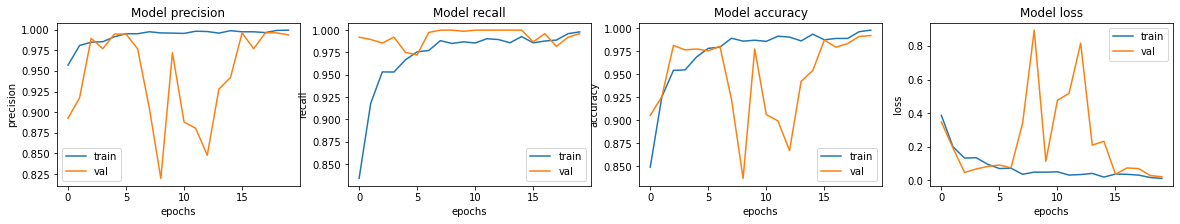

In [56]:


fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])



In [57]:
loss, acc, prec, rec = model.evaluate(test_ds)

5/5 [==============================] - 25s 5s/step - accuracy: 0.8029 - loss: 1.4205 - recall: 1.0000 - precision: 0.7602
